# Faites de votre mieux! (20%) 

In [1]:
from comet_ml import Experiment

In [2]:
from dotenv import load_dotenv
load_dotenv(r".env")
import os

In [3]:
comet_api_key = os.environ.get('COMET_API_KEY')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.calibration import CalibrationDisplay, calibration_curve
import pickle
from plots import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

#### Loading data

In [5]:
data_path = os.environ.get('DATA_DIR')

In [6]:
print(load_dotenv(r".env"))

True


In [7]:
train_data_path_2 = "./nhl_2016to2019_adv.csv"
test_data_path_2 = "./nhl_2020_adv_1.csv"

In [8]:
train_data_2=pd.read_csv(train_data_path_2)
test_data_2=pd.read_csv(test_data_path_2)

In [9]:
train_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305760 entries, 0 to 305759
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   period                       305760 non-null  float64
 1   periodTimeInSeconds          305760 non-null  int64  
 2   isGoal                       305760 non-null  int64  
 3   typeDeTir                    305760 non-null  object 
 4   x                            305760 non-null  float64
 5   y                            305760 non-null  float64
 6   distanceToNet                305760 non-null  float64
 7   relativeAngleToNet           305760 non-null  float64
 8   previousEventTypeId          305760 non-null  object 
 9   previousX                    301611 non-null  float64
 10  previousY                    301612 non-null  float64
 11  distanceFromPrevious         301611 non-null  float64
 12  timeDiff                     305760 non-null  int64  
 13 

In [10]:
train_data_2.sample(3)

,period,periodTimeInSeconds,isGoal,typeDeTir,x,y,distanceToNet,relativeAngleToNet,previousEventTypeId,previousX,...,rebond,angleChange,vitesse,gameTime,homePlayer,awayPlayer,homePenaltySecondsRemaining,awayPenaltySecondsRemaining,attackingTeamPlayer,DefendingTeamPlayer
177638,1.0,472,0,Wrist Shot,-69.0,-40.0,45.177428,-62.300527,FACEOFF,-69.0,...,False,0.0,1.800000,472.0,5,5,0,0,5,5
52606,3.0,625,1,Deflected,82.0,2.0,8.246211,0.666200,FACEOFF,69.0,...,False,0.0,4.770000,3025.0,5,5,0,0,5,5
64548,3.0,468,0,Snap Shot,-71.0,7.0,20.248457,20.224859,GIVEAWAY,-35.0,...,False,0.0,1.981053,2868.0,5,5,0,0,5,5


In [11]:
# Vérifier s'il y a des NaN dans tout le DataFrame
nan_nb = train_data_2.isna().any().sum()

# Afficher le résultat
print(f"Y a-t-il des NaN dans le DataFrame ? {nan_nb}")

# Vérifier s'il y a des NaN dans chaque colonne
nan_columns = train_data_2.columns[train_data_2.isna().any()]

# Afficher les colonnes avec des NaN
if not nan_columns.empty:
    print(f"Colonnes avec des NaN : {nan_columns}")
else:
    print("Aucune colonne avec NaN.")

Y a-t-il des NaN dans le DataFrame ? 5
Colonnes avec des NaN : Index(['previousX', 'previousY', 'distanceFromPrevious', 'angleChange',
       'vitesse'],
      dtype='object')


In [12]:
train_data_2.dropna(inplace=True)

In [13]:
# Calculer la proportion de valeurs infinies dans le dataframe
inf_proportion = train_data_2.replace([np.inf, -np.inf], np.nan).isna().mean().mean()

# Afficher le nombre total de lignes dans le dataframe
num_rows = len(train_data_2)

print(f"Proportion de valeurs infinies : {inf_proportion:.2%}")
print(f"Nombre total de lignes dans le dataframe : {num_rows}")

Proportion de valeurs infinies : 0.08%
Nombre total de lignes dans le dataframe : 301594


In [14]:
train_data_2 = train_data_2.replace([np.inf, -np.inf], np.nan).dropna()

In [15]:
dummy_object = pd.get_dummies(train_data_2[['typeDeTir', 'previousEventTypeId']])
data = train_data_2.merge(dummy_object, left_index=True, right_index=True)
train_data_2_correct = data.drop(labels = ['typeDeTir', 'previousEventTypeId'], axis = 1)

In [16]:
train_data_2_correct.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295973 entries, 0 to 305759
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   period                            295973 non-null  float64
 1   periodTimeInSeconds               295973 non-null  int64  
 2   isGoal                            295973 non-null  int64  
 3   x                                 295973 non-null  float64
 4   y                                 295973 non-null  float64
 5   distanceToNet                     295973 non-null  float64
 6   relativeAngleToNet                295973 non-null  float64
 7   previousX                         295973 non-null  float64
 8   previousY                         295973 non-null  float64
 9   distanceFromPrevious              295973 non-null  float64
 10  timeDiff                          295973 non-null  int64  
 11  rebond                            295973 non-null  bool  

In [17]:
train_data_2_correct.sample(3)

,period,periodTimeInSeconds,isGoal,x,y,distanceToNet,relativeAngleToNet,previousX,previousY,distanceFromPrevious,...,typeDeTir_Wrist Shot,previousEventTypeId_BLOCKED_SHOT,previousEventTypeId_FACEOFF,previousEventTypeId_GIVEAWAY,previousEventTypeId_GOAL,previousEventTypeId_HIT,previousEventTypeId_MISSED_SHOT,previousEventTypeId_PENALTY,previousEventTypeId_SHOT,previousEventTypeId_TAKEAWAY
194339,1.0,505,0,-51.0,-2.0,39.051248,-2.935673,20.0,22.0,74.95,...,True,False,True,False,False,False,False,False,False,False
202916,3.0,709,0,-61.0,-7.0,29.832868,-13.570434,-96.0,30.0,50.93,...,True,False,False,False,False,True,False,False,False,False
42614,3.0,705,0,16.0,37.0,82.734515,19.241878,96.0,-16.0,95.96,...,True,False,False,False,False,True,False,False,False,False


In [18]:
# on garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data_2_correct.drop('isGoal', axis=1)
y_train_select = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)

## Forêt aléatoire

#### Version par défault de sklearn

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a02/milestone2/31e4f2f3a9504712b575d727fdd7fb1e
COMET INFO:   Others:
COMET INFO:     Name : Modèle Forêt aléatoire original
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : None
COMET INFO:     criterion                : gini
COMET INFO:     max_depth                : None
COMET INFO:     max_features             : sqrt
COMET INFO:     max_leaf_nodes           : None
COMET INFO:     max_samples              : None
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
CO

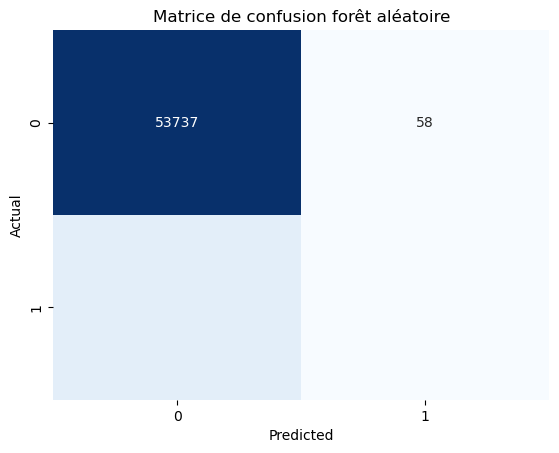

Accuracy: 0.9091139454345806
Accuracy pour la classe 0 : 0.9989218328840971
Accuracy pour la classe 1 : 0.014444444444444444
Matrice de confusion : 
[[53737    58]
 [ 5322    78]]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a02/milestone2/7e0412faf11a4d0d843509d7f4c30965
COMET INFO:   Metrics:
COMET INFO:     accuracy         : 0.9091139454345806
COMET INFO:     accuracy_class_0 : 0.9989218328840971
COMET INFO:     accuracy_class_1 : 0.014444444444444444
COMET INFO:   Others:
COMET INFO:     Name : Modèle Forêt aléatoire original
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : None
COMET INFO:     criterion                : gini
COMET INFO:     max_depth                : None
COMET INFO:     max_features             : sqrt
COM

In [24]:
experience_comet = True
# Initialisation de l'expérience Comet ML
if experience_comet:
    exp_rf = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_rf.set_name("Modèle Forêt aléatoire original")

# on garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data_2_correct.drop('isGoal', axis=1)
y_train_select = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)

# Initialisation de la forêt aléatoire
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Entraîenement
rf.fit(X_train, y_train)

# prédictions sur l'ensemble de validation
y_pred_rf = rf.predict(X_valid)

# Calcul de l'accuracy et de la matrice de confusion
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

# Visualisation de la matrice de confusion
plt.figure()
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion forêt aléatoire')
plt.show()

# Calcul des accuracies par classe
accuracy_class_0_rf = (y_pred_rf[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_rf = (y_pred_rf[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

print(f"Accuracy: {accuracy_rf}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_rf}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_rf}")
print(f'Matrice de confusion : \n{conf_matrix_rf}')

hyperparams_rf = {
        "bootstrap": rf.bootstrap,
        "criterion": rf.criterion,
        "max_depth": rf.max_depth,
        "max_features": rf.max_features,
        "min_samples_leaf": rf.min_samples_leaf,
        "min_samples_split": rf.min_samples_split,
        "n_estimators": rf.n_estimators,
        "random_state": rf.random_state
    }

model = rf
if experience_comet:
    # Créer le répertoire 'models' s'il n'existe pas
    if not os.path.exists('models'):
        os.makedirs('models')

    pickle.dump(model, open("models/random_forest_origin.pkl", "wb"))

    # Enregistrement des métriques
    exp_rf.log_model("Modèle Forêt aléatoire original", "models/random_forest_origin.pkl")
    exp_rf.log_metric("accuracy", accuracy_rf)
    exp_rf.log_metric("accuracy_class_0", accuracy_class_0_rf)
    exp_rf.log_metric("accuracy_class_1", accuracy_class_1_rf)
    exp_rf.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_rf, title="Matrice de confusion : forêt aléatoire")
    exp_rf.log_parameters(hyperparams_rf)
    exp_rf.add_tag("random_forest")
    # Fermeture de l'expérience Comet ML
    exp_rf.end()

#### Séléction de caractéristiques

##### Gain d'informations

In [ ]:
"""from sklearn.feature_selection import SelectKBest, mutual_info_classif

column_names= X_train_select_try.columns

selector = SelectKBest(mutual_info_classif, k=20)

X_new = selector.fit_transform(X, y)

selected_features_indices = selector.get_support(indices=True)

selected_feature_names = [column_names[i] for i in selected_features_indices]
print("Caractéristiques sélectionnées:", selected_feature_names)"""

In [120]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

column_names = X_train_select.columns
best_k = 0
best_score = 0

# Tester différentes valeurs de 'k'
for k in range(15, len(column_names) + 1):
    # Création et ajustement du sélecteur
    selector = SelectKBest(mutual_info_classif, k=k)
    X_new = selector.fit_transform(X_train_select, y_train_select)

    # Entraînement et évaluation - la validation croisée
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    scores = cross_val_score(rf, X_new, y_train_select, cv=5, scoring='accuracy')  
    mean_score = scores.mean()

    # Mise à jour de la meilleure performance
    if mean_score > best_score:
        best_k = k
        best_score = mean_score

# Afficher des résultats
print(f'Meilleur k: {best_k} avec une accuracy moyenne de {best_score}')


Meilleur k: 35 avec une accuracy moyenne de 0.9088903379866082


In [121]:
len(column_names)

36

On utilise donc 35 caractéristiques sur les 36 ce qui ne change pas beaucoup le modèle

Matrice de confusion :
 [[52567  1228]
 [ 5250   150]]


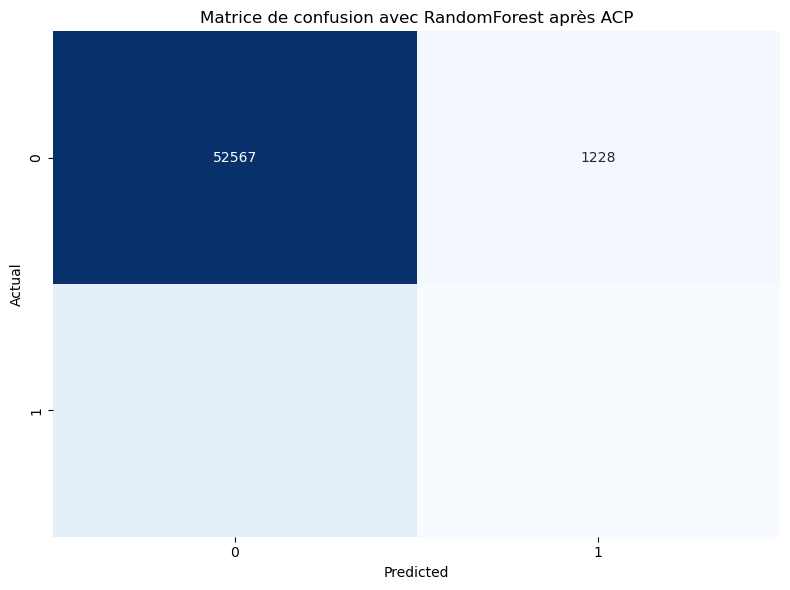

Accuracy avec RandomForest après ACP: 0.8905650815102627
Accuracy pour la classe 0 : 0.9771725996839855
Accuracy pour la classe 1 : 0.027777777777777776


In [128]:
# random forest with PCA
from sklearn.decomposition import PCA

experience_comet = False

if experience_comet:
    exp_rf = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_rf.set_name("Modèle RandomForest avec ACP")

# instanciation
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

# transformation en ACP sur l'ensemble de validation
X_valid_pca = pca.transform(X_valid)

# initialisation et entrainement du modèle
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_pca, y_train)

# Prédictions
y_pred_rf = rf.predict(X_valid_pca)

# Calcul de l'accuracy et de la matrice de confusion
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

# Matrice de confusion
print("Matrice de confusion :\n", conf_matrix_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion avec RandomForest après ACP')
plt.tight_layout()
plt.show()

# Calcul de l'accuracy par classe
accuracy_class_0_rf = (y_pred_rf[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_rf = (y_pred_rf[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

print(f"Accuracy avec RandomForest après ACP: {accuracy_rf}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_rf}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_rf}")
print(f'Matrice de confusion : \n{conf_matrix_rf}')

hyperparams_rf = {
    "criterion": rf.criterion,
    "max_depth": rf.max_depth,
    "max_features": rf.max_features,
    "min_samples_leaf": rf.min_samples_leaf,
    "min_samples_split": rf.min_samples_split,
    "n_estimators": rf.n_estimators,
    "random_state": rf.random_state,
    "pca_components": pca.n_components_
}

if experience_comet:
    if not os.path.exists('models'):
        os.makedirs('models')

    pickle.dump(rf, open("models/random_forest_after_pca.pkl", "wb"))

    exp_rf.log_model("Modèle RandomForest après ACP", "models/random_forest_after_pca.pkl")
    exp_rf.log_metric("accuracy", accuracy_rf)
    exp_rf.log_metric("accuracy_class_0", accuracy_class_0_rf)
    exp_rf.log_metric("accuracy_class_1", accuracy_class_1_rf)
    exp_rf.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_rf, title="Matrice de confusion : RandomForest après ACP")
    exp_rf.log_parameters(hyperparams_rf)
    exp_rf.add_tag("random_forest_after_pca")
    
    exp_rf.end()

#### Rééquilibration des classes 

In [19]:
df = train_data_2_correct.copy()

t = df[df['isGoal']==1]
t = t.head(len(t))
f = df[df['isGoal']==0]
f = f.sample(frac=1).head(len(t))

try_df = pd.concat([t, f], ignore_index=True)

occurrences = try_df['isGoal'].value_counts()
print("Nombre d'occurrences pour chaque valeur dans 'isGoal':\n", occurrences)

Nombre d'occurrences pour chaque valeur dans 'isGoal':
 isGoal
1    27027
0    27027
Name: count, dtype: int64


In [20]:
# on garde que les caractéristique qu'on veut étudier ici
X_train_select_try = try_df.drop('isGoal', axis=1)
y_train_select_try = try_df['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_try, X_valid_try, y_train_try, y_valid_try = train_test_split(X_train_select_try, y_train_select_try, test_size=0.2, random_state=42)

#####  Grille aléatoire - meilleurs hyperparametres

In [131]:
# Recherche avec grille aléatoire pour trouver les meilleurs hyperparametres 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
#from scipy.stats import uniform as sp_uniform



# Définir l'espace des hyperparamètres
param_dist = {
    'criterion': ["gini", "entropy"],
    'bootstrap': [True, False],
    'max_depth': range(10, 50, 10),
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': range(1, 4, 1),
    'min_samples_split': range(2, 10, 2),
    'n_estimators': [100, 200, 300]
}

# Initialiser le modèle
model = RandomForestClassifier(random_state=42, verbose=1)

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(model, 
                                param_distributions=param_dist, 
                                n_iter=32, 
                                scoring='accuracy', 
                                cv=5,
                                n_jobs=-1)

# Entraîner RandomizedSearchCV
random_search.fit(X_train_try, y_train_try)

# Afficher les résultats
print("Meilleurs hyperparamètres : ", random_search.best_params_)
print("Meilleure performance (AUC) : ", random_search.best_score_)



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Do

Meilleurs hyperparamètres :  {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': True}
Meilleure performance (AUC) :  0.6851514759664323


In [22]:
"""rf = RandomForestClassifier(
    bootstrap= True, 
    criterion= 'gini', 
    max_depth= 20, 
    max_features= 'sqrt', 
    min_samples_leaf= 3, 
    min_samples_split= 8, 
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)"""

experience_comet = True

if experience_comet:
    exp_rf = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_rf.set_name("Modèle RandomForest 50/50 - best hyperparametre")

# Création du modèle avec les meilleurs hyperparamètres
best_params = random_search.best_params_
rf = RandomForestClassifier(**best_params)

# Entraîenement
rf.fit(X_train_try, y_train_try)

# prédictions sur l'ensemble de validation
y_pred_rf_try = rf.predict(X_valid_try)

# Calcul de l'accuracy et de la matrice de confusion
accuracy_rf_try = accuracy_score(y_valid_try, y_pred_rf_try)
conf_matrix_rf_try = confusion_matrix(y_valid_try, y_pred_rf_try)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_try, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion forêt aléatoire')
plt.show()

# Calcul des accuracies par classe
accuracy_class_0_rf_try = (y_pred_rf_try[y_valid_try.values == 0] == 0).sum() / (y_valid_try.values == 0).sum()
accuracy_class_1_rf_try = (y_pred_rf_try[y_valid_try.values == 1] == 1).sum() / (y_valid_try.values == 1).sum()

print(f"Accuracy: {accuracy_rf_try}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_rf_try}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_rf_try}")
print(f'Matrice de confusion : \n{conf_matrix_rf_try}')

hyperparams_rf_try = {
    "criterion": rf.criterion,
    "max_depth": rf.max_depth,
    "max_features": rf.max_features,
    "min_samples_leaf": rf.min_samples_leaf,
    "min_samples_split": rf.min_samples_split,
    "n_estimators": rf.n_estimators,
    "random_state": rf.random_state
}

if experience_comet:
    if not os.path.exists('models'):
        os.makedirs('models')

    pickle.dump(rf, open("models/random_forest_50-50_best_param.pkl", "wb"))

    exp_rf.log_model("Modèle RandomForest après ACP", "models/random_forest_50-50_best_hyp-param.pkl")
    exp_rf.log_metric("accuracy", accuracy_rf_try)
    exp_rf.log_metric("accuracy_class_0", accuracy_class_0_rf_try)
    exp_rf.log_metric("accuracy_class_1", accuracy_class_1_rf_try)
    exp_rf.log_confusion_matrix(y_true=y_valid_try, y_predicted=y_pred_rf_try, title="Matrice de confusion : RandomForest 50-50 - best hyperparametre")
    exp_rf.log_parameters(hyperparams_rf_try)
    exp_rf.add_tag("random_forest_50-50_best_hyp-param")
    exp_rf.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a02/milestone2/0433767e667e4beb965edefb98f99388



NameError: name 'random_search' is not defined

## Réseau de neurones 

In [21]:
from sklearn.neural_network import MLPClassifier

In [25]:
experience_comet = False

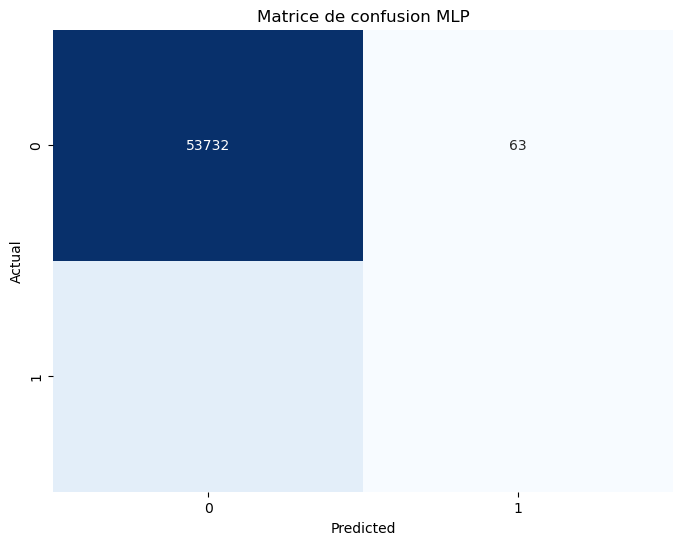

Accuracy (MLP): 0.9079314131261086
Accuracy pour la classe 0 : 0.998828887443071
Accuracy pour la classe 1 : 0.0024074074074074076
Matrice de confusion : 
[[53732    63]
 [ 5387    13]]


In [25]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get("COMET_API_KEY"),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("Modèle MLPClassifier")

# Entraînement du modèle MLP
mlp = MLPClassifier(hidden_layer_sizes=(126, 64), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=300, 
                    random_state=42)
mlp.fit(X_train, y_train)

# Prédictions et évaluation du modèle
y_pred_mlp = mlp.predict(X_valid)
accuracy_mlp = accuracy_score(y_valid, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_valid, y_pred_mlp)
# Calcul des accuracies par classe
accuracy_class_0_mlp = (y_pred_mlp[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_mlp = (y_pred_mlp[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion MLP')
plt.show()

print(f"Accuracy (MLP): {accuracy_mlp}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_mlp}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_mlp}")
print(f'Matrice de confusion : \n{conf_matrix_mlp}')

if experience_comet : 
    pickle.dump(model, open("models/mlp_model.pkl", "wb"))

    experience.log_model("Modèle MLPClassifier", "models/mlp_model.pkl")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_mlp, title="Matrice de confusion MLP")
    experience.log_metric("accuracy", accuracy_mlp)
    experience.add_tag("Neural_network")
    experience.end()

In [23]:
from sklearn.neural_network import MLPClassifier
experience_comet = False 

if experience_comet:
    exp_mlp = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_mlp.set_name("Modèle MLPClassifier")

# Entraînement du modèle MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=300, 
                    random_state=42)
mlp.fit(X_train, y_train)

# Prédictions et évaluation du modèle
y_pred_mlp = mlp.predict(X_valid)
accuracy_mlp = accuracy_score(y_valid, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_valid, y_pred_mlp)
# Calcul des accuracies par classe
accuracy_class_0_mlp = (y_pred_mlp[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_mlp = (y_pred_mlp[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion MLP')
plt.show()

print(f"Accuracy (MLP): {accuracy_mlp}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_mlp}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_mlp}")
print(f'Matrice de confusion : \n{conf_matrix_mlp}')

models=mlp
if experience_comet:
    # Enregistrement des hyperparamètres
    hyperparams_mlp = {
        "hidden_layer_sizes": mlp.hidden_layer_sizes,
        "activation": mlp.activation,
        "solver": mlp.solver,
        "max_iter": mlp.max_iter,
        "random_state": mlp.random_state
    }
    exp_mlp.log_parameters(hyperparams_mlp)
    exp_mlp.log_metric("accuracy", accuracy_mlp)
    exp_mlp.log_metric("accuracy_class_0", accuracy_class_0_mlp)
    exp_mlp.log_metric("accuracy_class_1", accuracy_class_1_mlp)
    exp_mlp.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_mlp, title="Matrice de confusion MLP")

    # Sauvegarde du modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    with open("models/mlp_model.pkl", "wb") as f:
        pickle.dump(mlp, f)
    exp_mlp.log_model("Modèle MLPClassifier", "models/mlp_model.pkl")
    exp_mlp.add_tag("Neural_network")
    # Fermeture de l'expérience Comet ML
    exp_mlp.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a02/milestone2/4f8bd219dfc24d448de27e47b78b9f07



Rechercher des meilleurs hyperparametres pour le RN avec les données équilibrées

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Définition de la grille d'hyperparamètres (sous forme de distributions si nécessaire)
param_distributions = {
    'hidden_layer_sizes': [(128, 64), (128, 128),(128,128,128)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'max_iter': [100, 300]
}

# Initialisation du MLPClassifier
mlp = MLPClassifier(random_state=42)

# Initialisation de la recherche aléatoire avec validation croisée
random_search = RandomizedSearchCV(
    mlp, 
    param_distributions, 
    n_iter=10,
    scoring='accuracy', 
    cv=3
)

# Entraînement de RandomizedSearchCV
random_search.fit(X_train_try, y_train_try)

# Affichage des meilleurs hyperparamètres
# Afficher les résultats
print("Meilleurs hyperparamètres : ", random_search.best_params_)
print("Meilleure performance (AUC) : ", random_search.best_score_)

best_params_MLP = random_search.best_params_

/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Meilleurs hyperparamètres :  {'solver': 'adam', 'max_iter': 100, 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu'}
Meilleure performance (AUC) :  0.6549501155424954


Meilleurs hyperparamètres :  {'solver': 'adam', 'max_iter': 100, 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu'}

Meilleure performance (AUC) :  0.6549501155424954

In [22]:

#best_params_MLP = {'solver': 'adam', 'max_iter': 100, 'hidden_layer_sizes': (128, 128, 128), 'activation': 'relu'}

/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


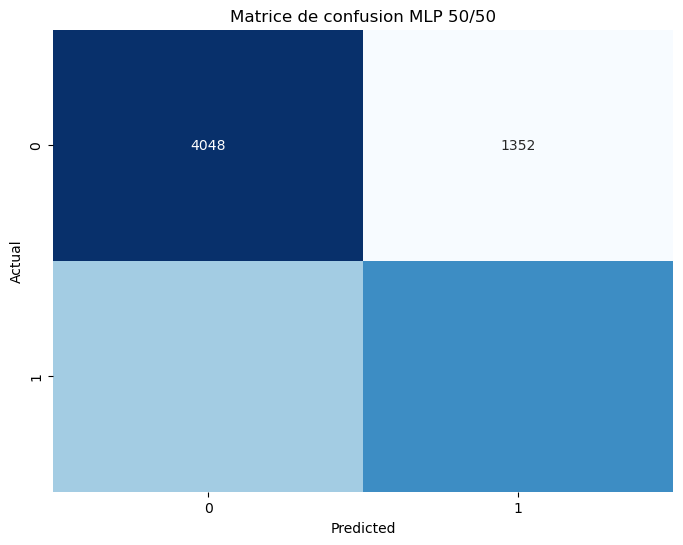

Accuracy (MLP): 0.6598834520395893
Accuracy pour la classe 0 : 0.7496296296296296
Accuracy pour la classe 1 : 0.5703197190907411
Matrice de confusion : 
[[4048 1352]
 [2325 3086]]


In [23]:
experience_comet = False 

if experience_comet:
    exp_mlp = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_mlp.set_name("Modèle MLPClassifier 50/50 - best hyperparametres ")

# Création du modèle avec les meilleurs hyperparamètres
mlp = MLPClassifier(**best_params_MLP)

# Entraînement du modèle MLP
mlp.fit(X_train_try, y_train_try)

# Prédictions et évaluation du modèle
y_pred_mlp_try = mlp.predict(X_valid_try)
accuracy_mlp_try = accuracy_score(y_valid_try, y_pred_mlp_try)
conf_matrix_mlp_try = confusion_matrix(y_valid_try, y_pred_mlp_try)
# Calcul des accuracies par classe
accuracy_class_0_mlp_try = (y_pred_mlp_try[y_valid_try.values == 0] == 0).sum() / (y_valid_try.values == 0).sum()
accuracy_class_1_mlp_try = (y_pred_mlp_try[y_valid_try.values == 1] == 1).sum() / (y_valid_try.values == 1).sum()


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp_try, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion MLP 50/50')
plt.show()

print(f"Accuracy (MLP): {accuracy_mlp_try}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_mlp_try}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_mlp_try}")
print(f'Matrice de confusion : \n{conf_matrix_mlp_try}')

models=mlp
if experience_comet:
    # Enregistrement des hyperparamètres
    hyperparams_mlp_try = {
        "hidden_layer_sizes": mlp.hidden_layer_sizes,
        "activation": mlp.activation,
        "solver": mlp.solver,
        "max_iter": mlp.max_iter,
        "random_state": mlp.random_state
    }
    exp_mlp.log_parameters(hyperparams_mlp_try)
    exp_mlp.log_metric("accuracy", accuracy_mlp_try)
    exp_mlp.log_metric("accuracy_class_0", accuracy_class_0_mlp_try)
    exp_mlp.log_metric("accuracy_class_1", accuracy_class_1_mlp_try)
    exp_mlp.log_confusion_matrix(y_true=y_valid_try, y_predicted=y_pred_mlp_try, title="Matrice de confusion MLP 50/50")

    # Sauvegarde du modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    with open("models/mlp_model_50-50_best_hyp-param.pkl", "wb") as f:
        pickle.dump(mlp, f)
    exp_mlp.log_model("Modèle MLPClassifier", "models/mlp_model_50-50_best_hyp-param.pkl")
    exp_mlp.add_tag("Neural_network")
    # Fermeture de l'expérience Comet ML
    exp_mlp.end()

#### Neural Network with PCA

Matrice de confusion :
 [[53795     0]
 [ 5400     0]]


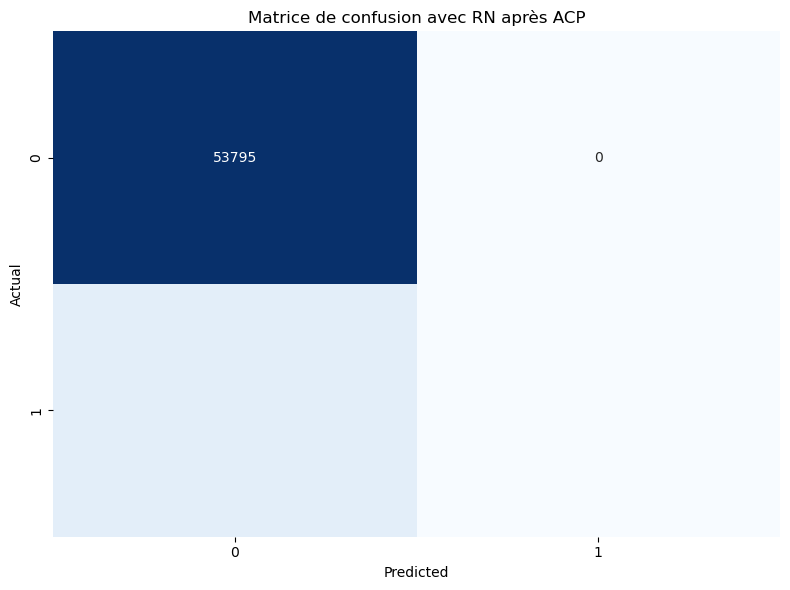

Accuracy avec RandomForest après ACP: 0.9087760790607314
Accuracy pour la classe 0 : 1.0
Accuracy pour la classe 1 : 0.0
Matrice de confusion : 
[[53795     0]
 [ 5400     0]]


In [24]:
# Neural Network with PCA
from sklearn.decomposition import PCA

experience_comet = False

if experience_comet:
    exp_rf = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_rf.set_name("Réseau de avec ACP")

# instanciation
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

# transformation en ACP sur l'ensemble de validation
X_valid_pca = pca.transform(X_valid)

# initialisation et entrainement du modèle
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_pca, y_train)

# Prédictions
y_pred_mlp = mlp.predict(X_valid_pca)

# Calcul de l'accuracy et de la matrice de confusion
accuracy_mlp = accuracy_score(y_valid, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_valid, y_pred_mlp)

# Matrice de confusion
print("Matrice de confusion :\n", conf_matrix_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion avec RN après ACP')
plt.tight_layout()
plt.show()

# Calcul de l'accuracy par classe
accuracy_class_0_mlp = (y_pred_mlp[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_mlp = (y_pred_mlp[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

print(f"Accuracy avec RandomForest après ACP: {accuracy_mlp}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_mlp}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_mlp}")
print(f'Matrice de confusion : \n{conf_matrix_mlp}')

hyperparams_mlp = {
        "hidden_layer_sizes": mlp.hidden_layer_sizes,
        "activation": mlp.activation,
        "solver": mlp.solver,
        "max_iter": mlp.max_iter,
        "random_state": mlp.random_state
    }

if experience_comet:
    if not os.path.exists('models'):
        os.makedirs('models')

    pickle.dump(rf, open("models/neural_network_after_pca.pkl", "wb"))

    exp_rf.log_model("Modèle RandomForest après ACP", "models/neural_network_after_pca.pkl")
    exp_rf.log_metric("accuracy", accuracy_mlp)
    exp_rf.log_metric("accuracy_class_0", accuracy_class_0_mlp)
    exp_rf.log_metric("accuracy_class_1", accuracy_class_1_mlp)
    exp_rf.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_mlp, title="Matrice de confusion : Neural Network après ACP")
    exp_rf.log_parameters(hyperparams_mlp)
    exp_rf.add_tag("neural_network")
    
    exp_rf.end()